In [110]:
import torch, os, math
import ctypes
from setuptools import setup
from torch.utils.cpp_extension import load_inline, BuildExtension, CppExtension
import timeit
import matplotlib.pyplot as plt


In [3]:
# Like so, lets do for metal kernels
cpp_prefix = """
#include <arm_neon.h>
"""


In [ ]:
prefix_sum = """

#include <arm_neon.h>
#include <cassert>

torch::Tensor prefix_sum_tensor_neon(torch::Tensor input) {
  TORCH_CHECK(input.dtype() == torch::kInt8, "Input must be int8");
  TORCH_CHECK(input.dim() == 1, "Input must be a 1D tensor");
  TORCH_CHECK(input.is_contiguous(), "Input must be contiguous");
  TORCH_CHECK(input.size(0) % 16 == 0, "Size must be divisible by 16");

  int64_t size = input.size(0);
  auto result = torch::empty_like(input);

  int8_t* in_ptr = input.data_ptr<int8_t>();
  int8_t* out_ptr = result.data_ptr<int8_t>();
  int8_t carry = 0;

  for (int64_t i = 0; i < size; i += 16) {
    int8x16_t sum = vld1q_s8(in_ptr + i);

    sum = vaddq_s8(sum, vextq_s8(vdupq_n_s8(0), sum, 15));
    sum = vaddq_s8(sum, vextq_s8(vdupq_n_s8(0), sum, 14));
    sum = vaddq_s8(sum, vextq_s8(vdupq_n_s8(0), sum, 12));
    sum = vaddq_s8(sum, vextq_s8(vdupq_n_s8(0), sum, 8));

    sum = vaddq_s8(sum, vdupq_n_s8(carry));
    carry = vgetq_lane_s8(sum, 15);
    vst1q_s8(out_ptr + i, sum);
  }

  return result;
}

torch::Tensor prefix_sum_tensor_scalar(torch::Tensor input) {
  TORCH_CHECK(input.dtype() == torch::kInt8, "Input must be int8");
  TORCH_CHECK(input.dim() == 1, "Input must be a 1D tensor");
  TORCH_CHECK(input.is_contiguous(), "Input must be contiguous");

  int64_t size = input.size(0);
  auto result = torch::empty_like(input);

  int8_t* in_ptr = input.data_ptr<int8_t>();
  int8_t* out_ptr = result.data_ptr<int8_t>();
  int8_t carry = 0;

  for (int64_t i = 0; i < size; i++) {
    out_ptr[i] = in_ptr[i] + carry;
    carry = out_ptr[i];
  }

  return result;
}
"""

vector_add = """
torch::Tensor vector_add_tensor_neon(torch::Tensor &v1, torch::Tensor &v2) {
  TORCH_CHECK(v1.dtype() == torch::kInt8, "Input must be int8");
  TORCH_CHECK(v2.dtype() == torch::kInt8, "Input must be int8");
  TORCH_CHECK(v1.dim() == 1, "Input must be a 1D tensor");
  TORCH_CHECK(v2.dim() == 1, "Input must be a 1D tensor");
  TORCH_CHECK(v1.is_contiguous(), "Input must be contiguous");
  TORCH_CHECK(v2.is_contiguous(), "Input must be contiguous");
  TORCH_CHECK(v1.size(0) % 16 == 0, "Size must be divisible by 16");
  TORCH_CHECK(v2.size(0) % 16 == 0, "Size must be divisible by 16");
  TORCH_CHECK(v1.size(0) == v2.size(0), "Size must be the same");

  torch::Tensor result = torch::empty_like(v1);
  int8_t* v1_ptr = v1.data_ptr<int8_t>();
  int8_t* v2_ptr = v2.data_ptr<int8_t>();
  int8_t* result_ptr = result.data_ptr<int8_t>();

  for (int64_t i = 0; i < v1.size(0); i += 16) {
    int8x16_t a = vld1q_s8(v1_ptr + i);
    int8x16_t b = vld1q_s8(v2_ptr + i);
    int8x16_t sum = vaddq_s8(a, b);
    vst1q_s8(result_ptr + i, sum);
  }
  return result;
}

torch::Tensor vector_add_tensor_scalar(torch::Tensor &v1, torch::Tensor &v2) {
  torch::Tensor result = torch::empty_like(v1);
  int8_t* v1_ptr = v1.data_ptr<int8_t>();
  int8_t* v2_ptr = v2.data_ptr<int8_t>();
  int8_t* result_ptr = result.data_ptr<int8_t>();

  for (int64_t i = 0; i < v1.size(0); i ++) {
    result_ptr[i] = v1_ptr[i] + v2_ptr[i];
  }
  return result;
}
"""

vector_reduce = """
int8_t vector_reduce_tensor_neon(torch::Tensor &v) {
  assert(v.size(0) % 16 == 0);
  int8_t* v_ptr = v.data_ptr<int8_t>();

  int8x16_t sumV = vdupq_n_s8(0);
  for (int64_t i = 0; i < v.size(0); i += 16) {
    int8x16_t data = vld1q_s8(v_ptr + i);
    sumV = vaddq_s8(sumV, data);
  }
  int8_t sum = 0;
  const int16x8_t sumV16 = vpaddlq_s8(sumV);
  const int32x4_t sumV32 = vpaddlq_s16(sumV16);
  const int64x2_t sumV64 = vpaddlq_s32(sumV32);
  sum = vgetq_lane_s64(sumV64, 0) + vgetq_lane_s64(sumV64, 1);
  return sum;
};

int8_t vector_reduce_tensor_scalar(torch::Tensor &v) {
  TORCH_CHECK(v.size(0) % 16 == 0, "Input must be int8");

  int8_t* v_ptr = v.data_ptr<int8_t>();

  int8_t sum = 0;
  for (int64_t i = 0; i < v.size(0); i += 16) {
    sum += v_ptr[i];
  }
  return sum;
};

"""

vector_max = """
int8_t vector_max_tensor_neon(torch::Tensor &v) {
  int8_t* v_ptr = v.data_ptr<int8_t>();
  int8x16_t maxV = vdupq_n_s8(0);
  for (int i = 0; i < v.size(0); i += 16) {
    int8x16_t data = vld1q_s8(v_ptr + i);
    maxV = vmaxq_s8(maxV, data);
  }
  const int8x8_t maxV8 = vpmax_s8(vget_low_s8(maxV), vget_high_s8(maxV));
  const int8x8_t maxV4 = vpmax_s8(maxV8, maxV8);
  const int8x8_t maxV2 = vpmax_s8(maxV4, maxV4);
  const int8x8_t maxV1 = vpmax_s8(maxV2, maxV2);
  int8_t max = vget_lane_s8(maxV1, 0);

  return max;
};

int8_t vector_max_tensor_scalar(torch::Tensor &v) {
  int8_t* v_ptr = v.data_ptr<int8_t>();
  int8_t max = -INFINITY;
  for (int i = 0; i < v.size(0); i += 16) {
    max = std::max(max, v_ptr[i]);
  }
  return max;
};

"""

vector_min = """
int8_t vectorMin(int8_t *v, int size) {
  assert(size % 16 == 0);
  int8x16_t minV = vdupq_n_s8(INT8_MAX);
  for (int i = 0; i < size; i += 16) {
    int8x16_t data = vld1q_s8(v + i);
    minV = vminq_s8(minV, data);
  }
  const int8x8_t minV8 = vpmin_s8(vget_low_s8(minV), vget_high_s8(minV));
  const int8x8_t minV4 = vpmin_s8(minV8, minV8);
  const int8x8_t minV2 = vpmin_s8(minV4, minV4);
  const int8x8_t minV1 = vpmin_s8(minV2, minV2);
  int8_t min = vget_lane_s8(minV1, 0);

  return min;
};

"""

conv_1d = """
int8_t *convolution_1d(int8_t *input, int iSize, int8_t *kernel, int kSize,
                       int &oSize, int padding, int stride) {
  assert(iSize % 16 == 0);
  assert(kSize % 16 == 0);

  const int outSize = (iSize + 2 * padding - kSize) / stride + 1;
  oSize = outSize;
  int8_t *output = new int8_t[outSize];

  for (int i = 0; i < outSize; i++) {
    int16x8_t sum = vdupq_n_s16(0); // Use int16 to avoid overflow

    for (int j = 0; j < kSize; j += 16) {
      int8x16_t inputV = vld1q_s8(input + i * stride + j);
      int8x16_t kernelV = vld1q_s8(kernel + j);
      int16x8_t prod1 = vmull_s8(vget_low_s8(inputV), vget_low_s8(kernelV));
      int16x8_t prod2 = vmull_s8(vget_high_s8(inputV), vget_high_s8(kernelV));
      sum = vaddq_s16(sum, prod1);
      sum = vaddq_s16(sum, prod2);
    }
    int result = vaddvq_s16(sum);
    output[i] = (int8_t)std::max(-128, std::min(127, result));
  }

  return output;
}

"""
conv_2d = """
int8_t *convolution_2d(int8_t *input, int iSide, int8_t *kernel, int kSide,
                       int **oSide, int padding, int stride) {
  assert(iSide % 4 == 0);
  assert(kSide % 4 == 0);
  int outSize = (iSide + 2 * padding - kSide) / stride + 1;
  *oSide = new int(outSize);
  int8_t *output = new int8_t[outSize * outSize];
  //
  for (int i = 0; i < outSize; i++) {
    for (int j = 0; j < outSize; j++) {
      int32_t sum = 0;
      // kside is 4
      for (int ki = 0; ki < kSide; ki += 4) {
        for (int kj = 0; kj < kSide; kj += 4) {
          int row = i * stride + ki - padding;
          int col = j * stride + kj - padding;
          if (row >= 0 && row < iSide && col >= 0 && col < iSide) {
            int8x16_t inputV = vld1q_s8(&input[row * iSide + col]);
            int8x16_t kernelV = vld1q_s8(&kernel[ki * kSide + kj]);
            int16x8_t prod1 =
                vmull_s8(vget_low_s8(inputV), vget_low_s8(kernelV));
            int16x8_t prod2 =
                vmull_s8(vget_high_s8(inputV), vget_high_s8(kernelV));
            int16x8_t sumV = vaddq_s8(prod1, prod2);
            sum += vaddvq_s16(sumV);
          }
        }
      }
      output[i * outSize + j] =
          static_cast<int8_t>(std::max(INT8_MIN, std::min(INT8_MAX, sum)));
    }
  }

  return output;
}

"""
soft_max = """


float32x4_t approxETaylorSeries(float32x4_t x) {
  // Use a polynomial approximation for exp(x), like Estrin's scheme
  // Approximation: exp(x) ≈ 1 + x + (x^2)/2 + (x^3)/6 + (x^4)/24
  float32x4_t one = vdupq_n_f32(1.0f);
  float32x4_t x2 = vmulq_f32(x, x);
  float32x4_t x3 = vmulq_f32(x2, x);
  float32x4_t x4 = vmulq_f32(x3, x);
  float32x4_t x5 = vmulq_f32(x4, x);

  float32x4_t a = vaddq_f32(one, x);
  float32x4_t b =
      vaddq_f32(vmulq_n_f32(x2, 0.5f), vmulq_n_f32(x3, 1.0f / 6.0f));
  float32x4_t c =
      vaddq_f32(vmulq_n_f32(x4, 1.0f / 24.0f), vmulq_n_f32(x5, 1.0f / 120.0f));

  return vaddq_f32(a, vaddq_f32(b, c));
}

float32x4_t approxEBitManipulation(float32x4_t x) {
  // Clamp x to prevent overflow/underflow
  x = vmaxq_f32(vminq_f32(x, vdupq_n_f32(88.0f)), vdupq_n_f32(-88.0f));

  // Convert ln(2) to float32x4_t
  const float32x4_t log2e = vdupq_n_f32(1.4426950408889634f); // log2(e)

  // Compute exponent base-2: 2^(x * log2(e))
  float32x4_t y = vmulq_f32(x, log2e);
  int32x4_t i = vcvtq_s32_f32(vsubq_f32(y, vdupq_n_f32(0.5f))); // Floor(y)
  float32x4_t f = vsubq_f32(y, vcvtq_f32_s32(i)); // Fractional part

  // Polynomial approximation for 2^f in range [-0.5, 0.5]
  float32x4_t poly =
      vaddq_f32(vdupq_n_f32(1.0f),
                vmulq_f32(f,
                          vaddq_f32(vdupq_n_f32(0.6931472f), // ln(2)
                                    vmulq_f32(f, vdupq_n_f32(0.2402265f)))));

  // Reconstruct 2^(x * log2(e)) using exponent bit-shifting trick
  int32x4_t exponent = vaddq_s32(i, vdupq_n_s32(127)); // Bias of 127
  exponent = vshlq_n_s32(exponent, 23); // Shift to exponent position
  float32x4_t result = vreinterpretq_f32_s32(exponent); // Reinterpret bits
  return vmulq_f32(result, poly);                       // Final approximation
}
float32x4_t approxERemez(float32x4_t x) {
  // Clamp x to prevent large overflows
  x = vmaxq_f32(vminq_f32(x, vdupq_n_f32(88.0f)), vdupq_n_f32(-88.0f));

  const float32x4_t c1 = vdupq_n_f32(0.9999997f);
  const float32x4_t c2 = vdupq_n_f32(0.6931472f);
  const float32x4_t c3 = vdupq_n_f32(0.2402265f);
  const float32x4_t c4 = vdupq_n_f32(0.0555051f);
  const float32x4_t c5 = vdupq_n_f32(0.0096181f);

  float32x4_t x2 = vmulq_f32(x, x);
  float32x4_t x3 = vmulq_f32(x2, x);
  float32x4_t x4 = vmulq_f32(x3, x);
  float32x4_t x5 = vmulq_f32(x4, x);

  return vaddq_f32(
      vaddq_f32(vaddq_f32(vaddq_f32(c1, vmulq_f32(x, c2)), vmulq_f32(x2, c3)),
                vmulq_f32(x3, c4)),
      vmulq_f32(x4, c5));
}

void softMax(float32_t *input, float32_t *output, int length) {
  float max_val = -INFINITY;
  int i = 0;

  { // Step 1: Find the maximum value for numerical stability

    float32x4_t max_vec = vdupq_n_f32(-INFINITY);
    for (; i <= length - 4; i += 4) {
      float32x4_t v = vld1q_f32(input + i);
      max_vec = vmaxq_f32(max_vec, v);
    }
    max_vec = vpmaxq_f32(max_vec, max_vec);
    max_vec = vpmaxq_f32(max_vec, max_vec);
    max_val = vgetq_lane_f32(max_vec, 0);
    // Handle remaining elements
    for (; i < length; i++) {
      max_val = std::max(max_val, input[i]);
    }
  }

  float sum_exp = 0.0f;
  { // Step 2: Compute exponentials and sum
    float32x4_t sum_vec = vdupq_n_f32(0.0f);
    i = 0;
    for (; i <= length - 4; i += 4) {
      float32x4_t v = vld1q_f32(input + i);
      float32x4_t exp_v = approxEBitManipulation(
          vsubq_f32(v, vdupq_n_f32(max_val))); // exp(x - max)
      vst1q_f32(output + i, exp_v);            // Store exponentials
      sum_vec = vaddq_f32(sum_vec, exp_v);     // Accumulate sum
    }

    // Sum up the elements in the vector register
    sum_vec = vpaddq_f32(sum_vec, sum_vec);
    sum_vec = vpaddq_f32(sum_vec, sum_vec);
    sum_exp = vgetq_lane_f32(sum_vec, 0);
    // Handle remaining elements
    for (; i < length; i++) {
      output[i] = std::exp(input[i] - max_val);
      sum_exp += output[i];
    }
  }

  { // Step 3: Normalize by dividing each element by sum_exp
    float32x4_t sum_inv = vdupq_n_f32(1.0f / sum_exp);
    i = 0;
    for (; i <= length - 4; i += 4) {
      float32x4_t v = vld1q_f32(output + i);
      vst1q_f32(output + i, vmulq_f32(v, sum_inv)); // Normalize
    }

    // Handle remaining elements
    for (; i < length; i++) {
      output[i] /= sum_exp;
    }
  }
}
"""

simd_kernels = load_inline(
    name="simd_kernels",
    cpp_sources=[cpp_prefix + prefix_sum + vector_add + vector_reduce + vector_max],
    functions=["prefix_sum_tensor_neon", 
               "prefix_sum_tensor_scalar", 
               "vector_add_tensor_neon",
               "vector_add_tensor_scalar",
               "vector_reduce_tensor_neon",
               "vector_reduce_tensor_scalar",
                "vector_max_tensor_neon",
                "vector_max_tensor_scalar"
               ],
    extra_cflags=["-std=c++17 -march=armv8.2-a+simd"],
    verbose=True
)


Using /Users/viranchee/Library/Caches/torch_extensions/py39_cpu as PyTorch extensions root...
The input conditions for extension module simd_kernels have changed. Bumping to version 10 and re-building as simd_kernels_v10...
Emitting ninja build file /Users/viranchee/Library/Caches/torch_extensions/py39_cpu/simd_kernels/build.ninja...
Building extension module simd_kernels_v10...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=simd_kernels_v10 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_clang\" -DPYBIND11_STDLIB=\"_libcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1002\" -isystem /Volumes/code/env/pymetal/lib/python3.9/site-packages/torch/include -isystem /Volumes/code/env/pymetal/lib/python3.9/site-packages/torch/include/torch/csrc/api/include -isystem /Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/include/python3.9 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -std=c++17 -march=armv8.2-a+simd -c /Users/viranchee/Library/Caches/torch_extensions/py39_cpu/simd_kernels/main.cpp -o main.o 
[2/2] c++ main.o -shared -L/Volumes/code/env/pymetal/lib/python3.9/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -undefined dynamic_lookup -o simd_kernels_v10.so


Loading extension module simd_kernels_v10...


In [ ]:

# Test Prefix Sum
test_range = [2**i for i in range(4, 22)]
neonTimes = []
torchTimes = []
cpu_python_times = []
cpu_cpp_times = []
metalTimes = []
for i in test_range:
    input_tensor = torch.zeros(i, dtype=torch.int8, device='cpu')
    # make every 1st element 1, 2nd element 0, 3rd element -1
    pattern = torch.tensor([1, 0, -1], dtype=torch.int8)
    input_tensor = pattern.repeat(i // 3 + 1)[:i]
    
    # Verify first
    result = simd_kernels.prefix_sum_tensor_neon(input_tensor)
    calculation = torch.cumsum(input_tensor, dim=0, dtype=torch.int8)
    assert torch.equal(result, calculation)
    # if (i < 2**16):
    #   calculation = simd_kernels.prefix_sum_tensor_cpu(input_tensor)
    #   assert torch.equal(result, calculation)
    # NeonTime
    timeNeon = timeit.timeit(lambda: simd_kernels.prefix_sum_tensor_neon(input_tensor), number=100)
    neonTimes.append(timeNeon)
    # TorchTime
    timeTorch = timeit.timeit(lambda: torch.cumsum(input_tensor, dim=0, dtype=torch.int8), number=100)
    torchTimes.append(timeTorch)
    # CPU Time
    # if (i < 2**16):
    #   pythonCpuTime = timeit.timeit(lambda: cpu_prefix_sum(input_tensor), number=100)
    #   cpu_python_times.append(pythonCpuTime)
    cppCpuTime = timeit.timeit(lambda: simd_kernels.prefix_sum_tensor_cpu(input_tensor), number=100)
    cpu_cpp_times.append(cppCpuTime)
    # MetalTime
    input_tensor.to('mps')
    timeMetal = timeit.timeit(lambda: torch.cumsum(input_tensor, dim=0, dtype=torch.int8), number=100)
    metalTimes.append(timeMetal)
    
plt.plot(test_range, neonTimes, label='Neon', color='green')
plt.plot(test_range[:len(cpu_python_times)], cpu_python_times, label='CPU', color='blue')
plt.plot(test_range[:len(cpu_cpp_times)], cpu_cpp_times, label='CPU C++', color='purple')
plt.plot(test_range, torchTimes, label='Torch', color='orange')
plt.plot(test_range, metalTimes, label='Metal', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Time')
plt.legend()
plt.show()


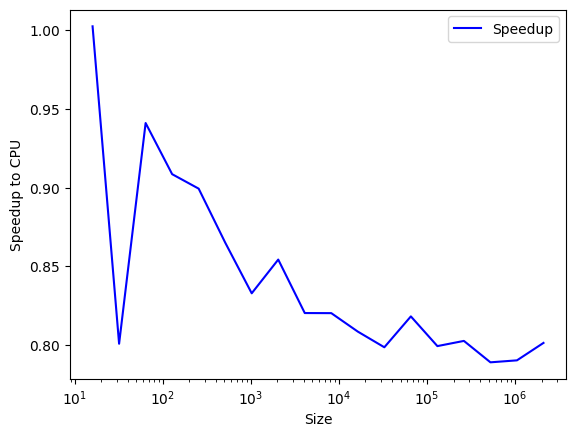

In [192]:
# Measure Speedup to the CPU version
speedup = [cpu_cpp_times[i] / neonTimes[i] for i in range(len(cpu_cpp_times))]
plt.plot(test_range[:len(cpu_cpp_times)], speedup, label='Speedup', color='blue')
plt.xlabel('Size')
plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Speedup to CPU')
plt.legend()
plt.show()


In [190]:
speedup

[0.9353211701882392,
 0.9414258022151658,
 0.9564775966814614,
 1.0132008062319025,
 0.9369147123895984,
 0.9101905718582948,
 0.8667903067601815,
 0.8868578471927296,
 0.7778350879574758,
 0.8054720178787352,
 0.8032633949253385,
 0.8040004798977335]